---
Example notebook to explain the usage of the code
---
Author: Pierre Burger

---

# First import all packages

In [1]:
import numpy as np
import pylab as plt
import modules
from astropy.io import fits
import treecorr
import matplotlib.pyplot as plt

## Define class

In [2]:
LensingMocks = modules.LensingMocks(download_dir='T17_data',output_dir='outputs',nres = 12, nsbins = 5)

## Just some code to load in real data is used to ass shape nosie

In [3]:


def load_sources(sbin):
    fits_image_filename = 'obs_data/K1000_filt_bin'+str(sbin)+'.cat'
    hdul = fits.open(fits_image_filename)
    table = hdul[1].data
    rac = table['RAJ2000']
    dec = table['DECJ2000']
    weight = table['recal_weight_C']
    e_1 = table['autocal_e1_C']
    e_2 = table['autocal_e2_C']

    return rac,dec,e_1,e_2,weight

## Load in some n(z) and define the N(z) that the code used to get the right number of galaxies ad the right redshift bin

1792136.0000000002 1785987.5683105988
3681319.0000000005 3678867.903055546
6148102.0 6145378.915288727
4544395.0 4543280.582441188
5096059.0 5096058.999999999


(0.0, 2.0)

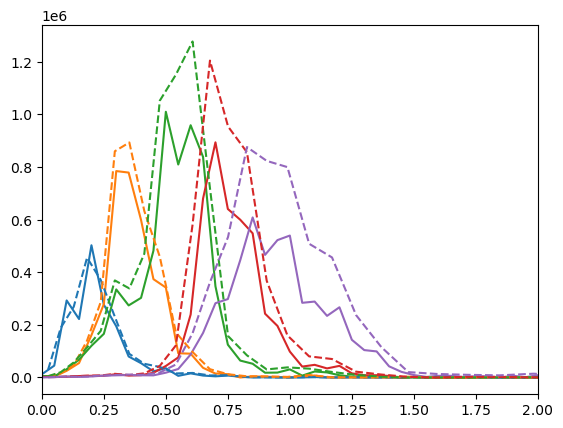

In [4]:
z_list = []
nz_list = []
for i in range(5):
    rac,dec,e_1,e_2,weight = load_sources(sbin=i+1)
    
    nz = np.loadtxt('nofz/K1000_TOMO'+str(i+1)+'_Nz.asc')

    plt.plot(nz[:60,0],nz[:60,1]*len(rac))
    
    z_list.append(nz[:,0])
    nz_list.append(nz[:,1]*len(rac))
    
LensingMocks.compute_T17_Nz(z_persbin=z_list, Nz_persbin=nz_list)

epsilon_data = []
for i in range(5):
    nz = np.loadtxt('nofz/K1000_TOMO'+str(i+1)+'_Nz.asc')
    rac,dec,e_1,e_2,weight = load_sources(sbin=i+1)

    print(np.sum(nz[:,1]*len(rac)),np.sum(LensingMocks.N_T17_persbin[i]))
    plt.plot(LensingMocks.zbins[:,1],LensingMocks.N_T17_persbin[i],c='C'+str(i),linestyle='--')
    
    

plt.xlim(0,2)

## Check if all files are available for the chosen line-of-sight (los) 

In [5]:
los = 0
LensingMocks.check_files(los=los)

All source files available
Density file T17_data/allskymap_nres12r000.delta_shell.dat available


## Prepare the galaxy postions using the density maps, which ensures we have source clustering

In [6]:
LensingMocks.create_gal_positions(los = los)

Reading density shells: 100%|██████████| 38/38 [07:58<00:00, 12.59s/it]


## Combine the single source maps using the postions determined above

In [7]:
LensingMocks.combine_source_planes(los = los)

Combining source planes: 100%|██████████| 38/38 [00:44<00:00,  1.18s/it]


## Create the final catalogues with columns: (ra, dec, kappa, gamma1, gamma2, eobs1, eobs2, weights)

In [9]:
(0.3/np.sqrt(2))**2

0.044999999999999984

In [8]:
gamma_tables = []
for sbin in range(5):
    rac,dec,e_1,e_2,weight = load_sources(sbin=sbin+1)
    epsilon_data = np.array([e_1/10,e_2/10,weight]) 
    gamma_tables.append(LensingMocks.create_sigma_shear_catalogue(los = 0, sbin = sbin, epsilon_data = epsilon_data))

## Compute the $\xi_\pm$ using treecorr to check if catalogues are properly created

In [9]:
 
for sbin1 in range(5):
    for sbin2 in np.arange(sbin1,5):

        cat1 = treecorr.Catalog(ra=gamma_tables[sbin1]['ra'], dec=gamma_tables[sbin1]['dec'], g1=gamma_tables[sbin1]['gamma1'], g2=-gamma_tables[sbin1]['gamma2'], w=gamma_tables[sbin1]['weights'], ra_units='deg', dec_units='deg')
        cat2 = treecorr.Catalog(ra=gamma_tables[sbin2]['ra'], dec=gamma_tables[sbin2]['dec'], g1=gamma_tables[sbin2]['gamma1'], g2=-gamma_tables[sbin2]['gamma2'], w=gamma_tables[sbin2]['weights'], ra_units='deg', dec_units='deg')

        # Set up the correlation function
        gg = treecorr.GGCorrelation(nbins=10, min_sep=1, max_sep=100, sep_units='arcmin')

        # Process the catalogue to compute xi+ and xi-
        gg.process(cat1,cat2)

        # Output the results to a file
        gg.write('outputs/xi'+str(sbin1)+'_'+str(sbin2)+'.dat')
        
        cat1 = treecorr.Catalog(ra=gamma_tables[sbin1]['ra'], dec=gamma_tables[sbin1]['dec'], g1=gamma_tables[sbin1]['eobs1'], g2=-gamma_tables[sbin1]['eobs2'], w=gamma_tables[sbin1]['weights'], ra_units='deg', dec_units='deg')
        cat2 = treecorr.Catalog(ra=gamma_tables[sbin2]['ra'], dec=gamma_tables[sbin2]['dec'], g1=gamma_tables[sbin2]['eobs1'], g2=-gamma_tables[sbin2]['eobs2'], w=gamma_tables[sbin2]['weights'], ra_units='deg', dec_units='deg')

        # Set up the correlation function
        gg = treecorr.GGCorrelation(nbins=10, min_sep=1, max_sep=100, sep_units='arcmin')

        # Process the catalogue to compute xi+ and xi-
        gg.process(cat1,cat2)

        # Output the results to a file
        gg.write('outputs/xi_noise_'+str(sbin1)+'_'+str(sbin2)+'.dat')



## Plot the $\xi_\pm$ for noisefree and noisy data

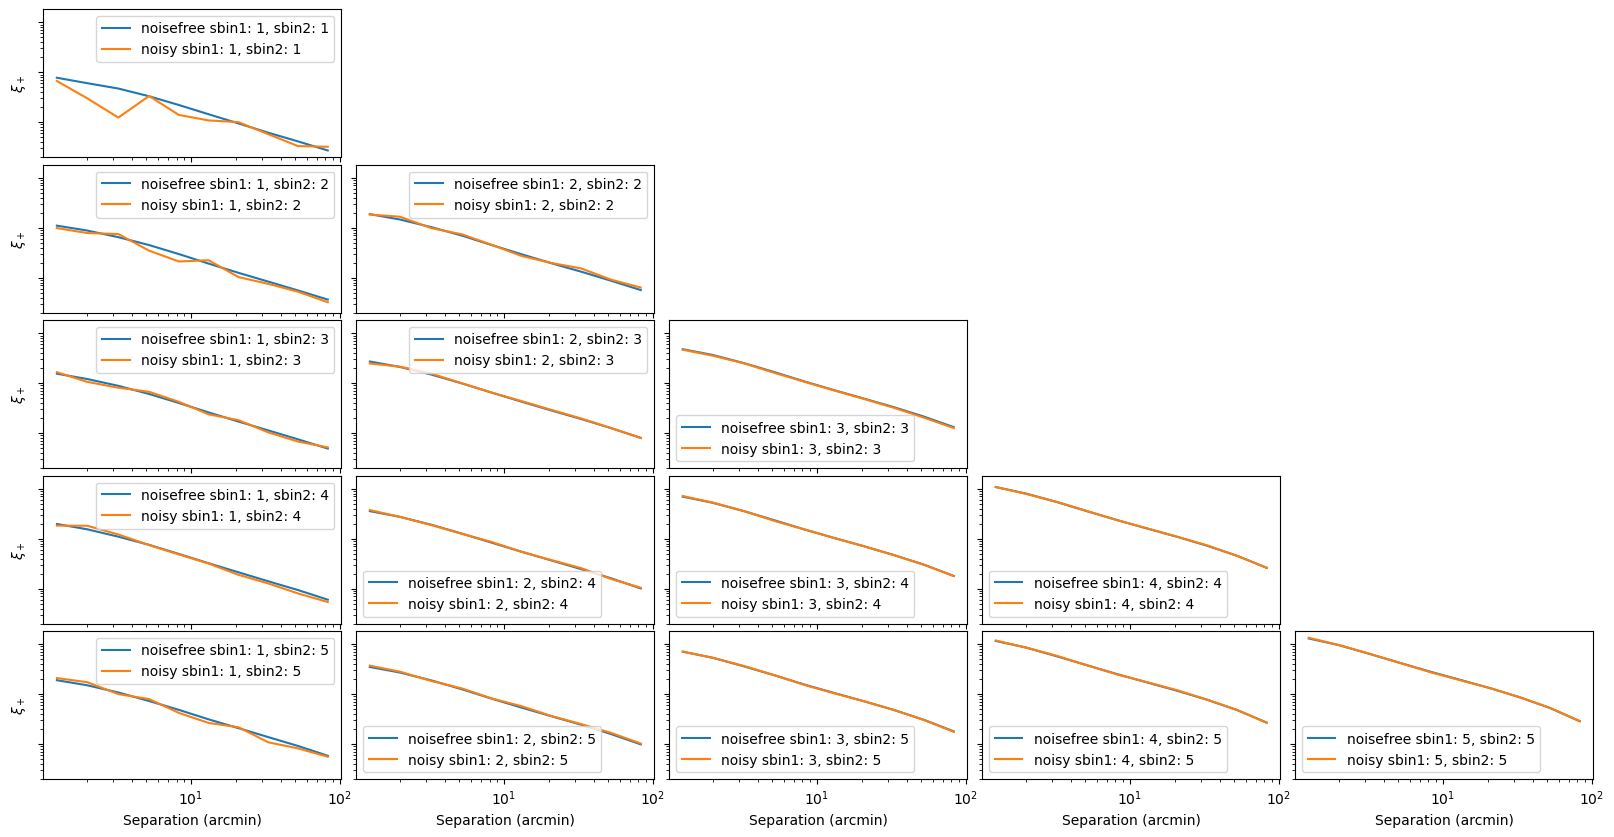

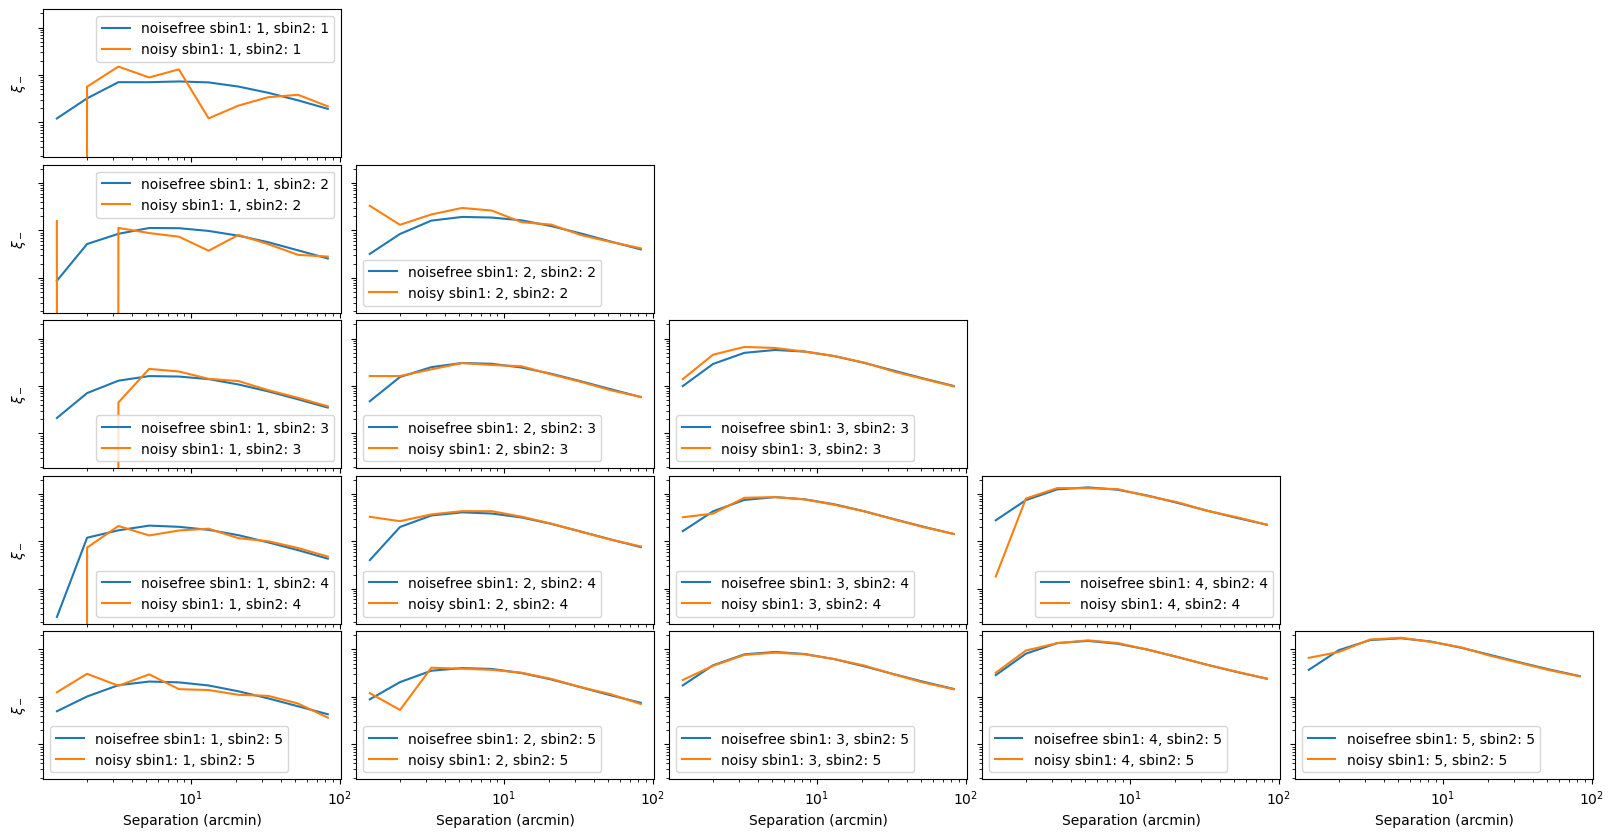

In [10]:

nsbins = 5
fig, axes = plt.subplots(nsbins, nsbins, figsize=(4 * nsbins, 2 * nsbins), sharex='col',sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(5):
    for j in range(i, 5):
        ax = axes[j, i]
        
        data = np.loadtxt('outputs/xi'+str(i)+'_'+str(j)+'.dat')
        ax.loglog(data[:,1],data[:,3], color='C0',label=f'noisefree sbin1: {i+1}, sbin2: {j+1}')
        
        data = np.loadtxt('outputs/xi_noise_'+str(i)+'_'+str(j)+'.dat')
        ax.loglog(data[:,1],data[:,3], color='C1',label=f'noisy sbin1: {i+1}, sbin2: {j+1}')
        
        ax.legend()
        
        if j != nsbins - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Separation (arcmin)')

        # Hide y tick labels except for the leftmost column
        if i != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$\xi_+$')
            
    for j in range(0, i):
            axes[j, i].axis('off')
  
plt.show()          
            
fig, axes = plt.subplots(nsbins, nsbins, figsize=(4 * nsbins, 2 * nsbins), sharex='col',sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for i in range(5):
    for j in range(i, 5):
        
        
        ax = axes[j, i]
        
        data = np.loadtxt('outputs/xi'+str(i)+'_'+str(j)+'.dat')
        ax.loglog(data[:,1],data[:,4], color='C0',label=f'noisefree sbin1: {i+1}, sbin2: {j+1}')
        
        data = np.loadtxt('outputs/xi_noise_'+str(i)+'_'+str(j)+'.dat')
        ax.loglog(data[:,1],data[:,4], color='C1',label=f'noisy sbin1: {i+1}, sbin2: {j+1}')
        
        ax.legend()
        if j != nsbins - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Separation (arcmin)')

        # Hide y tick labels except for the leftmost column
        if i != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$\xi_-$')
            
    for j in range(0, i):
            axes[j, i].axis('off')
            
plt.show()


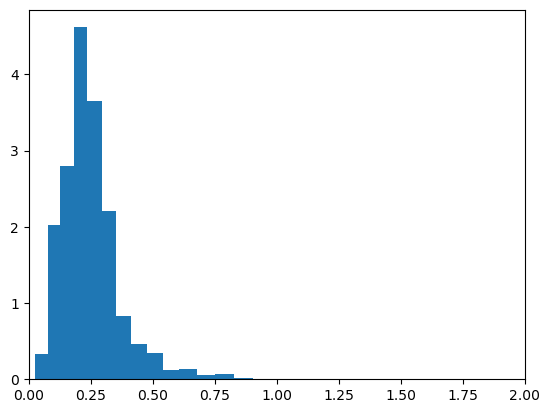

In [20]:
zbins = np.loadtxt('nofz/nofz_takashi_zbins.dat')
plt.hist(gamma_tables[0]['redshift'],bins=zbins[:,1],density=True)
plt.xlim(0,2)
plt.show()

In [17]:
nz

array([[0.0506, 0.0252, 0.0763],
       [0.1023, 0.0763, 0.1286],
       [0.1553, 0.1286, 0.1823],
       [0.2097, 0.1823, 0.2375],
       [0.2657, 0.2375, 0.2943],
       [0.3233, 0.2943, 0.3528],
       [0.3827, 0.3528, 0.4132],
       [0.4442, 0.4132, 0.4757],
       [0.5078, 0.4757, 0.5405],
       [0.5739, 0.5405, 0.6078],
       [0.6425, 0.6078, 0.6779],
       [0.714 , 0.6779, 0.7508],
       [0.7885, 0.7508, 0.827 ],
       [0.8664, 0.827 , 0.9067],
       [0.9479, 0.9067, 0.9902],
       [1.0334, 0.9902, 1.0778],
       [1.1233, 1.0778, 1.17  ],
       [1.2179, 1.17  , 1.2671],
       [1.3176, 1.2671, 1.3695],
       [1.423 , 1.3695, 1.4779],
       [1.5345, 1.4779, 1.5927],
       [1.6527, 1.5927, 1.7146],
       [1.7784, 1.7146, 1.8442],
       [1.9121, 1.8442, 1.9823],
       [2.0547, 1.9823, 2.1297],
       [2.2071, 2.1297, 2.2873],
       [2.3703, 2.2873, 2.4563],
       [2.5454, 2.4563, 2.6379],
       [2.7337, 2.6379, 2.8333],
       [2.9367, 2.8333, 3.0441],
       [3.